In [154]:
import numpy as np
#Lab Tools package from Werner Boeglin, FIU
import LT.box as B

# normalized distribution functions
from numba_stats import truncnorm

#Importing Minuit object
from iminuit import Minuit
#Cost function for Minuit minimization
import iminuit.cost as cost

import math
import copy as C

import File_read_write as FRW
import pickle

In [155]:
# load historgram

#For smaller range use the one below
#h = B.histo2d(file = 'Metaprime_Momega_totalMC_rebin_diffrange_new.data')
h = B.histo2d(file = 'Metaprime_Momega_omegaMC_rebin_origrange.data')


# bin centers
xb = h.x_bin_center
yb = h.y_bin_center

# bin edges
xbe = h.x_bins
ybe = h.y_bins

# labels

l_omega =  r'$M_{\pi^{+},\pi^{-},\pi^{0}}$'
l_etap = r'$M_{\pi^{+},\pi^{-},\eta}$'
l_title = ''





file='2017_widecoherent_good_events_signal_8komega_20ksignal.npz'
data_dict=FRW.NPZ_file(file)
Momega=data_dict['mpippimpi0']
Metap=data_dict['metap']

sel_Momega=B.in_between(xbe.min(),xbe.max(),Momega)
sel_Metap=B.in_between(ybe.min(), ybe.max(),Metap)

sel_Momega_Metap=sel_Momega & sel_Metap

M_omega=Momega[sel_Momega_Metap]
M_etap=Metap[sel_Momega_Metap]






### Setup Bernstein Polynomials

$B_{i,n}(x) = \begin{pmatrix} n \\ i\end{pmatrix} x^i(1-x)^{n-i}$

for $i = 0, 1, ..., n$

Here $\begin{pmatrix} n \\ i\end{pmatrix}$ are binomial coefficients

in general if they are degfined over an interval $(a, b)$ the norm is

$\int_a^b B_{i,n}(x) = \frac{(b-a)}{n+1}$

In [156]:
class BP:
    def __init__(self,n,interval=[0,1]):
        self.size=n
        self.int=interval
        self.norm=(interval[1]-interval[0])/(n+1)
        coef=(n+1)*[[0]]
        b_pol=[]
        for i in range(n+1):
            coef[i]=[1]
            b_pol.append(SI_INT.BPoly(coef,self.int))
            coef[i]=[0]
        self.bpol=b_pol
    def __getitem__(self,n):
        return self.bpol[n]
                
        
        

[[<matplotlib.lines.Line2D at 0x15a5c7940>],

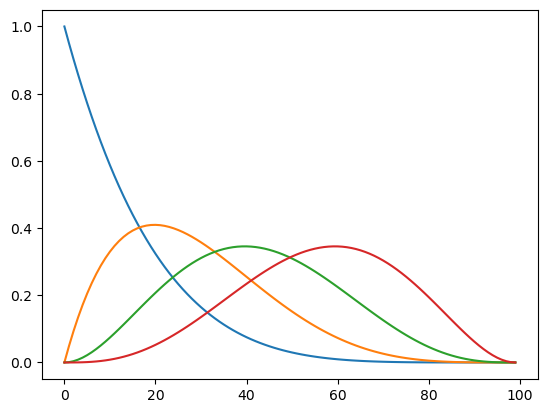

In [157]:
pol5=BP(5)
points=np.linspace(0,1,100)
B.pl.figure()
[B.pl.plot(pol5[i](points)) for  i in [0,1,2,3]]

### Bi-linear background model

given by a rectangular array $x_r[0] < x_r[1]$ and $y_r[0] < y_r[1]$ defining the 4 corners

at each corners are the z-values $z_1, z_2, z_3, z_4$ in CCW direction defining the surface 

the interpolating function is

 $ Z(x,y) =  \frac{x y \left(z_{1} - z_{2} + z_{3} - z_{4}\right) + x \left(- y_{1} z_{3} + y_{1} z_{4} - y_{2} z_{1} + y_{2} z_{2}\right) + x_{1} y_{1} z_{3} - x_{1} y_{2} z_{2} - x_{2} y_{1} z_{4} + x_{2} y_{2} z_{1} + y \left(x_{1} z_{2} - x_{1} z_{3} - x_{2} z_{1} + x_{2} z_{4}\right)}{\left(x_{1} - x_{2}\right) \left(y_{1} - y_{2}\right)} $
 
 and the norm is
 
 $ N = \frac{\left(x_{1} - x_{2}\right) \left(y_{1} - y_{2}\right) \left(z_{1} + z_{2} + z_{3} + z_{4}\right)}{4} $


In [158]:
class BLin:
    def __init__(self,xr,yr,z):
        """
        b-linear interpolation in a rectangular are defined by 4 corners
        
        # The 4 corners are :

        P1 = S.Matrix([x1, y1, z1])
        
        P2 = S.Matrix([x2, y1, z2])
        
        P3 = S.Matrix([x2, y2, z3])
        
        P4 = S.Matrix([x1, y2, z4])

        Parameters
        ----------
        xr : size 2, float array
            limits of the x-range.
        yr : size 2, float array
            limits of the y-range.
        z : size 4, parameter array
            the z values for the 4 corners: z1, z2, z3, z4
            these are fit parameters

        Returns
        -------

        """
        # these are the xy ranges 
        self.xrange=xr
        self.yrange=yr
      

    def Get_value(self,x,y,z1,z2,z3,z4):
                
        """
        calculate interpolated value
            z = (x*y*(z1 - z2 + z3 - z4) + 
                 x*(-y1*z3 + y1*z4 - y2*z1 + y2*z2) + 
                 x1*y1*z3 - x1*y2*z2 - x2*y1*z4 + x2*y2*z1 + 
                 y*(x1*z2 - x1*z3 - x2*z1 + x2*z4))/
                ((x1 - x2)*(y1 - y2))

        """
        x1 = self.xrange[0]
        y1 = self.yrange[0]
        
        x2 = self.xrange[1]
        y2 = self.yrange[1]
        
        
        zval= (x*y*(z1 - z2 + z3 - z4) + 
             x*(-y1*z3 + y1*z4 - y2*z1 + y2*z2) + 
             x1*y1*z3 - x1*y2*z2 - x2*y1*z4 + x2*y2*z1 + 
             y*(x1*z2 - x1*z3 - x2*z1 + x2*z4)) / ( (x1 - x2)*(y1 - y2) )

        self.norm = (x1 - x2)*(y1 - y2)*(z1 + z2 + z3 + z4)/4
        
        return zval
    
    def Get_value_pdf(self,x,y,z1,z2,z3,z4):
        
        
        x1 = self.xrange[0]
        y1 = self.yrange[0]

        x2 = self.xrange[1]
        y2 = self.yrange[1]

        self.norm = (x1 - x2)*(y1 - y2)*(z1 + z2 + z3 + z4)/4

        cdf = (x1 - x)*(y1 - y)*(x1*y1*z1 + x1*y1*z2 + x1*y1*z3 + x1*y1*z4 - \
                                     2*x1*y2*z1 - 2*x1*y2*z2 + x1*y*z1 + x1*y*z2 - \
                                     x1*y*z3 - x1*y*z4 - 2*x2*y1*z1 - 2*x2*y1*z4 + \
                                     4*x2*y2*z1 - 2*x2*y*z1 + 2*x2*y*z4 + x*y1*z1 - \
                                     x*y1*z2 - x*y1*z3 + x*y1*z4 - 2*x*y2*z1 + \
                                     2*x*y2*z2 + x*y*z1 - x*y*z2 + 
                                     x*y*z3 - x*y*z4)/ \
                                    (4*(x1 - x2)*(y1 - y2))
        return cdf/self.norm


In [159]:
# fit 2 gaussians
#Limits for fit paramters
no_bound = [-np.inf, np.inf]
is_pos =   [1e-6, np.inf]
is_prob = [1e-6, 1.]


# initial values
IV = {}


# omega peak
IV['x0'] = [0.780, [0.775, 0.785]]
IV['sig_x'] = [0.0129, [0.008, 0.02]]

# omega amplitude as a function of etap mass 
IV['cy0'] = [0.07, is_pos]
IV['cy1'] = [0.1, is_pos]
IV['cy2'] = [0.1, is_pos]


# eta peak
IV['x0e'] = [0.555, [0.545, 0.565]]
IV['sig_xe'] = [0.0143, [0.005, 0.015]]

# eta amplitude as a function of etap mass 
IV['cye0'] = [0., is_pos]
IV['cye1'] = [0., is_pos]
IV['cye2'] = [0., is_pos]

# etap peak
IV['y0'] = [0.957, [0.955, 0.965]]
IV['sig_y'] = [0.658, [0.006, 0.015]]
IV['co_A'] = [0.5, [0,0.5]]
IV['co_sig_y'] = [0.52, [0,50]]
 

# etap Amplitude as a function of omega mass
IV['cx0'] = [0., is_pos]
IV['cx1'] = [10., is_pos]
IV['cx2'] = [10., is_pos]
IV['cx3'] = [10., is_pos]


# backgrpound paramters z-value at the edges
xr = [xbe.min(), xbe.max()]
yr = [ybe.min(), ybe.max()]

IV['z1'] = [0.9480, is_pos]
IV['z2'] = [1.404, is_pos]
IV['z3'] = [2.2843, is_pos]
IV['z4'] = [2.813, is_pos]

ZP = [IV['z1'][0], IV['z2'][0], IV['z3'][0], IV['z4'][0]]


# fractions for extended unbinned likelihood fit
IV['o']    = [25, is_pos]
IV['e']  = [0., is_pos]
IV['ep'] = [25, is_pos]
IV['b']  = [25, is_pos]

#Interval for Bernstein polynomials
interv_x = [xbe.min(), xbe.max()]
interv_y = [ybe.min(), ybe.max()]

# Bernstein polynomial for etap amplitude
BP_etap = BP(8, interv_x)

# Bernstein polynomial for omega amplitude
BP_omega = BP(2, interv_y)
 

# bi-linear background
Bckg = BLin(xr, yr, ZP)
 

# Normalized PDF's for likelihood fit

In [160]:
#For details check https://iminuit.readthedocs.io/en/stable/notebooks/cost_functions.html
# Dependence on etaprime mass is denoted by y and dependence on omega mass id denoted by x

def Omega_PDF(x,y,cy0,cy1,cy2,x0,sig_x):
    
    Amp_omega=(cy0*BP_omega[0](y)+cy1*BP_omega[1](y)+cy2*BP_omega[2](y))/BP_omega.norm
    Dist_omega=truncnorm.pdf(x,xbe.min(), xbe.max(),x0,sig_x)
    return Amp_omega*Dist_omega


def Eta_PDF(x,y,cye0,cye1,cye2,x0e,sig_xe):
    
    Amp_eta=(cye0*BP_omega[0](y)+cye1*BP_omega[1](y)+cye2*BP_omega[2](y))/BP_omega.norm
    Dist_eta=truncnorm.pdf(x,xbe.min(), xbe.max(),x0e,sig_xe)
    return Amp_eta*Dist_eta


def Truncnorm_sum(x,xmin,xmax,x0,sig,co_A,co_sig):
    
    return (truncnorm.pdf(x,xmin,xmax,x0,sig)+co_A*truncnorm.pdf(x,xmin,xmax,x0,co_sig*sig))/(1+co_A)


def Etprime_PDF(x,y,cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y):
    
    Amp_etap=(cx0*BP_etap[1](x)+cx1*BP_etap[3](x)+cx2*BP_etap[5](x)+cx3*BP_etap[6](x))/BP_etap.norm
    Dist_etap=Truncnorm_sum(y,ybe.min(),ybe.max(),y0,sig_y,co_A,co_sig_y)
    return Amp_etap*Dist_etap
    
    
def Bckg_PDF(x,y,z1,z2,z3,z4):
    
    return Bckg.Get_value(x,y,z1,z2,z3,z4)/Bckg.norm


0.09648763511206572


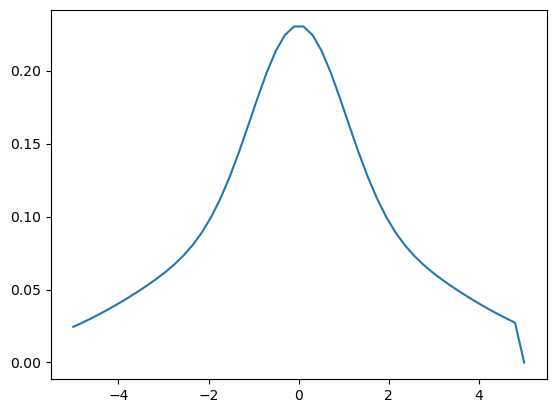

In [161]:
xx=np.linspace(-5,5)
y=Truncnorm_sum(xx,-5,5,0,1,2,3)
B.pl.figure() ;B.pl.plot(xx,y)
y.sum()*np.diff(xx)[0]
print(Truncnorm_sum(2,-5,5,0,1,2,3))




In [162]:
#Total function
def Total_F_PDF(xy, cy0,cy1,cy2,x0,sig_x,\
            cye0,cye1,cye2,x0e,sig_xe,\
            cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y,\
            z1,z2,z3,z4 ):
    
    x,y=xy
    norm=cy0+cy1+cy2+cye0+cye1+cye2+cx0+cx1+cx2+cx3+1
    
    tot= np.array([Omega_PDF(x,y,cy0,cy1,cy2,x0,sig_x)/norm,\
            Eta_PDF(x,y,cye0,cye1,cye2,x0e,sig_xe)/norm,\
            Etprime_PDF(x,y,cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y)/norm,\
            Bckg_PDF(x,y,z1,z2,z3,z4)/norm])
    
    return tot
    
#Logarithem of totl function    
def Total_logF_PDF(xy, cy0,cy1,cy2,x0,sig_x,\
            cye0,cye1,cye2,x0e,sig_xe,\
            cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y,\
            z1,z2,z3,z4):
    
    total= Total_F_PDF(xy, cy0,cy1,cy2,x0,sig_x,\
            cye0,cye1,cye2,x0e,sig_xe,\
            cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y,\
            z1,z2,z3,z4 )

    return np.log(np.sum(total,axis=0))


#List of total fit parameters
Fit_par=['cy0','cy1','cy2','x0','sig_x',\
            'cye0','cye1','cye2','x0e','sig_xe',\
            'cx0','cx1','cx2','cx3','y0','sig_y','co_A','co_sig_y',\
            'z1','z2','z3','z4']



In [163]:
cy0,cy1,cy2,x0,sig_x,\
            cye0,cye1,cye2,x0e,sig_xe,\
            cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y,\
            z1,z2,z3,z4=[IV[k][0] for k in Fit_par]
print(Total_logF_PDF((0.6,0.97), cy0,cy1,cy2,x0,sig_x,\
            cye0,cye1,cye2,x0e,sig_xe,\
            cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y,\
            z1,z2,z3,z4))

x,y=(0.6,0.97)

print(Omega_PDF(x,y,cy0,cy1,cy2,x0,sig_x))
print(Eta_PDF(x,y,cye0,cye1,cye2,x0e,sig_xe))
print(Etprime_PDF(x,y,cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y))
print(Bckg_PDF(x,y,z1,z2,z3,z4))

1.3264631034069412
3.859205830910495e-41
0.0
108.42958082524743
9.38620586352031


# Unbinned likelihood fit

In [164]:
# multivariate fit

unbinned_NLL = cost.UnbinnedNLL((M_omega[:], M_etap[:]), Total_logF_PDF, log = True)

# initialize values

init_values = [IV[k][0] for k in Fit_par]

Mi = Minuit(unbinned_NLL,  *init_values)

# set the bounds
for k in Fit_par:
    Mi.limits[k] = IV[k][1]

    
Mi.values['cye0']=0
Mi.values['cye1']=0
Mi.values['cye2']=0    
    
    
#fix eta amplitude
Mi.fixed["cye0"]= True
Mi.fixed["cye1"]= True
Mi.fixed["cye2"]= True
Mi.fixed['x0e']= True
Mi.fixed['sig_xe']= True    


In [165]:
#Execute fit
Mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.648e+05                 │             Nfcn = 1684              │
│ EDM = 7.97e-05 (Goal: 0.0002)    │           time = 60.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ cy0      │   0.87    │   0.11    │            │            │  1e-06  │         │       │
│ 1 │ cy1      │   2.93    │   0.32    │            │            │  1e-06  │         │       │
│ 2 │ cy2      │    9.6    │    0.7    │            │            │  1e-06  │         │       │
│ 3 │ x0       │ 781.10e-3 │  0.21e-3  │            │            │  0.775  │  0.785  │       │
│ 4 │ sig_x    │ 14.94e-3  │  0.18e-3  │            │            │  0.008  │  0.02   │       │
│ 5 │ cye0     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 6 │ cye1     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 7 │ cye2     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 8 │ x0e      │   0.555   │   0.006   │            │            │  0.545  │  0.565  │  yes  │
│ 9 │ sig_xe   │ 14.30e-3  │  0.14e-3  │            │            │  0.005  │  0.015  │  yes  │
│ 10│ cx0      │   3.26    │   0.29    │            │            │  1e-06  │         │       │
│ 11│ cx1      │   25.0    │    1.8    │            │            │  1e-06  │         │       │
│ 12│ cx2      │    0.7    │    0.4    │            │            │  1e-06  │         │       │
│ 13│ cx3      │   2.12    │   0.27    │            │            │  1e-06  │         │       │
│ 14│ y0       │ 957.93e-3 │  0.06e-3  │            │            │  0.955  │  0.965  │       │
│ 15│ sig_y    │  9.63e-3  │  0.10e-3  │            │            │  0.006  │  0.015  │       │
│ 16│ co_A     │   0.500   │   0.004   │            │            │    0    │   0.5   │       │
│ 17│ co_sig_y │   0.429   │   0.011   │            │            │    0    │   50    │       │
│ 18│ z1       │    0.7    │    1.2    │            │            │  1e-06  │         │       │
│ 19│ z2       │   0.00    │   0.08    │            │            │  1e-06  │         │       │
│ 20│ z3       │    0.2    │    0.5    │            │            │  1e-06  │         │       │
│ 21│ z4       │    10     │    12     │            │            │  1e-06  │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│          │       cy0       cy1       cy2        x0     sig_x      cye0      cye1      cye2       x0e    sig_xe       cx0       cx1       cx2       cx3        y0     sig_y      co_A  co_sig_y        z1        z2        z3        z4 │
├──────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [166]:
#Fix some of the parameters and fit again

#Mi.fixed['ay0'] = True
Mi.fixed['x0'] = True
Mi.fixed['sig_x'] = True
Mi.fixed['x0e'] = True
Mi.fixed['sig_xe'] = True
Mi.fixed['y0'] = True
Mi.fixed['sig_y'] = True
Mi.fixed['co_sig_y'] = True
#Mi.fixed['cx0'] = True
#Mi.fixed['z1'] = True


Mi.migrad()



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.648e+05                 │             Nfcn = 1963              │
│ EDM = 9.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ cy0      │   0.87    │   0.11    │            │            │  1e-06  │         │       │
│ 1 │ cy1      │   2.93    │   0.32    │            │            │  1e-06  │         │       │
│ 2 │ cy2      │    9.6    │    0.7    │            │            │  1e-06  │         │       │
│ 3 │ x0       │ 781.10e-3 │  0.21e-3  │            │            │  0.775  │  0.785  │  yes  │
│ 4 │ sig_x    │ 14.94e-3  │  0.18e-3  │            │            │  0.008  │  0.02   │  yes  │
│ 5 │ cye0     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 6 │ cye1     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 7 │ cye2     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 8 │ x0e      │   0.555   │   0.006   │            │            │  0.545  │  0.565  │  yes  │
│ 9 │ sig_xe   │ 14.30e-3  │  0.14e-3  │            │            │  0.005  │  0.015  │  yes  │
│ 10│ cx0      │   3.26    │   0.28    │            │            │  1e-06  │         │       │
│ 11│ cx1      │   25.0    │    1.7    │            │            │  1e-06  │         │       │
│ 12│ cx2      │    0.7    │    0.4    │            │            │  1e-06  │         │       │
│ 13│ cx3      │   2.12    │   0.26    │            │            │  1e-06  │         │       │
│ 14│ y0       │ 957.93e-3 │  0.06e-3  │            │            │  0.955  │  0.965  │  yes  │
│ 15│ sig_y    │  9.63e-3  │  0.10e-3  │            │            │  0.006  │  0.015  │  yes  │
│ 16│ co_A     │   0.500   │   0.004   │            │            │    0    │   0.5   │       │
│ 17│ co_sig_y │   0.429   │   0.011   │            │            │    0    │   50    │  yes  │
│ 18│ z1       │    0.7    │    1.2    │            │            │  1e-06  │         │       │
│ 19│ z2       │   0.00    │   0.09    │            │            │  1e-06  │         │       │
│ 20│ z3       │    0.2    │    0.5    │            │            │  1e-06  │         │       │
│ 21│ z4       │    10     │    14     │            │            │  1e-06  │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│          │       cy0       cy1       cy2        x0     sig_x      cye0      cye1      cye2       x0e    sig_xe       cx0       cx1       cx2       cx3        y0     sig_y      co_A  co_sig_y        z1        z2        z3        z4 │
├──────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

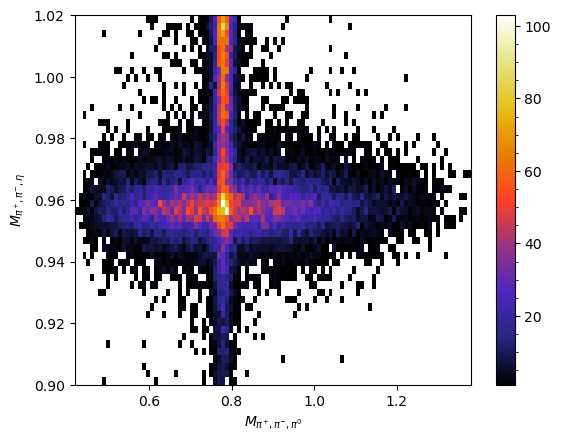

In [167]:
# Make a histogram of experimental data

# make histogram of exp.data
h_exp = B.histo2d(M_omega, M_etap, bins = [h.nbins_x, h.nbins_y], \
                  range = [[xbe.min(), xbe.max()],[ybe.min(),ybe.max()]], \
                 xlabel = l_omega, ylabel = l_etap, title = '')

B.pl.figure(); h_exp.plot()

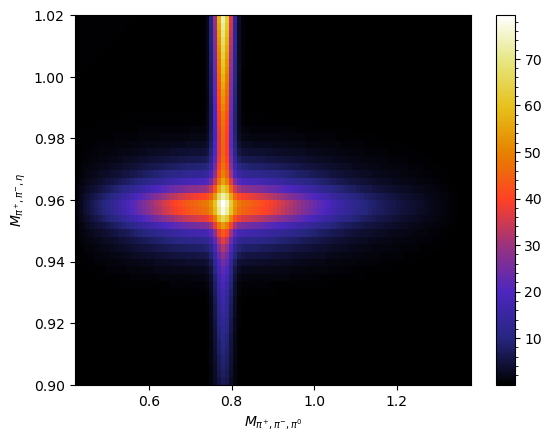

In [168]:
# Plot fit results

#Get fit parameters
final_pars = [Mi.params[k].value for k in Fit_par]

# save final parameters as pickle object
o = open('final_pars.pkl', 'wb')
pickle.dump(Mi.params, o)
o.close()


# calculate the fitted values
xx,yy = np.meshgrid(h_exp.x_bin_center, h_exp.y_bin_center)
S_log_pdf = Total_logF_PDF((xx, yy), *final_pars)
# need to integrate PDF and normalize to number of events instead 1
S_pdf = np.exp(S_log_pdf)*h_exp.x_bin_width*h_exp.y_bin_width*M_omega.shape[0]

h_likefit = C.copy(h_exp)
h_likefit.bin_content = S_pdf.T
h_likefit.bin_error = np.sqrt(h_likefit.bin_content)
h_res = h - h_likefit
B.pl.figure();B.pl.close('all')
h_likefit.plot()


Data events(22897.0, 151.3175469005495)
Fit events(22897.258797019433, 151.31840204356982)


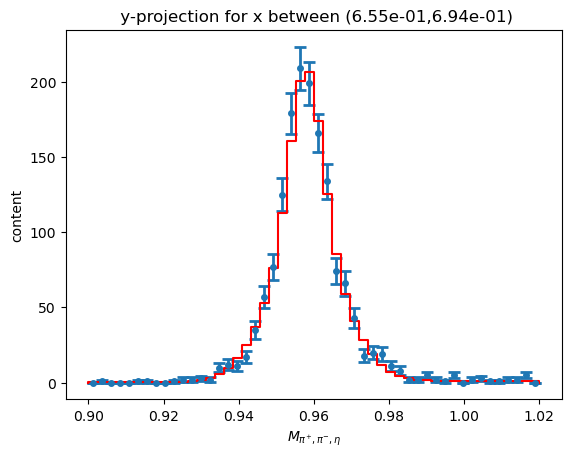

In [169]:
#%% compare etap projection
B.pl.figure(); B.pl.close('all')
o_range = (0.65, 0.7)
h_exp.project_y(range = o_range).plot_exp()
h_likefit.project_y(range = o_range).plot(filled = False, color = 'r')

print("Data events"+str(h_exp.sum()))
print("Fit events"+str(h_likefit.sum()))

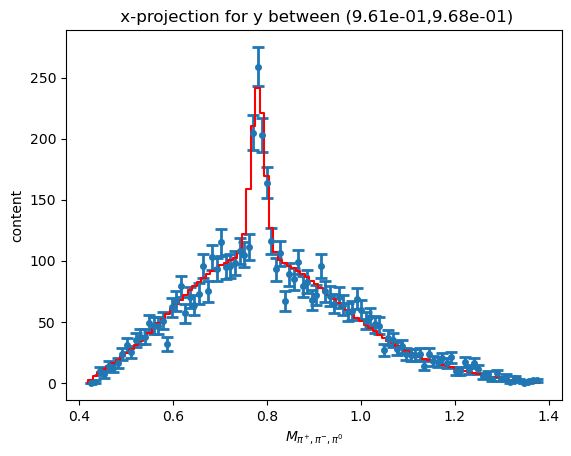

In [170]:
B.pl.figure()
e_range = (0.96,0.97)
h_exp.project_x(range = e_range).plot_exp()
h_likefit.project_x(range = e_range).plot(filled = False, color = 'r')

# Extended Unbinned likelihood fit

In [122]:
#The model in this case has to return the integral of the density and the density itself (which must be vectorized)
#Total function
def F_PDF_SUM(xy, cy0,cy1,cy2,x0,sig_x,\
            cye0,cye1,cye2,x0e,sig_xe,\
            cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y,\
            z1,z2,z3,z4,o,e,ep,b ):
    
    x,y=xy
    norm=cy0+cy1+cy2+cye0+cye1+cye2+cx0+cx1+cx2+cx3+1
    
    
    tot= (o*Omega_PDF(x,y,cy0,cy1,cy2,x0,sig_x)/(cy0+cy1+cy2)+\
            e*Eta_PDF(x,y,cye0,cye1,cye2,x0e,sig_xe)/(cye0+cye1+cye2)+\
            ep*Etprime_PDF(x,y,cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y)/(cx0+cx1+cx2+cx3)+\
            b*Bckg_PDF(x,y,z1,z2,z3,z4))
    
    return (o+e+ep+b),tot



#List of total fit parameters
Par_list=['cy0','cy1','cy2','x0','sig_x',\
            'cye0','cye1','cye2','x0e','sig_xe',\
            'cx0','cx1','cx2','cx3','y0','sig_y','co_A','co_sig_y',\
            'z1','z2','z3','z4','o','e','ep','b']

In [115]:
#Setting up the fit
unbinned_ext_NLL = cost.ExtendedUnbinnedNLL((M_omega[:], M_etap[:]),F_PDF_SUM )

init_val = [IV[k][0] for k in Par_list]

MT = Minuit(unbinned_ext_NLL,  *init_val)

# set the bounds
for k in Par_list:
    MT.limits[k] = IV[k][1]

       
MT.values['e']=0       
    
#fix eta amplitude
MT.fixed["cye0"]= True
MT.fixed["cye1"]= True
MT.fixed["cye2"]= True
MT.fixed['x0e']= True
MT.fixed['sig_xe']= True    
MT.fixed['e']= True    

#fix omega, etaprime parameters 
MT.fixed['x0']= True
MT.fixed['y0']= True

MT.migrad()

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.951e+05                 │             Nfcn = 10954             │
│ EDM = -4.95e+05 (Goal: 0.0002)   │           time = 324.8 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ cy0      │ 1.1013e2  │ 0.0000e2  │            │            │  1e-06  │         │       │
│ 1 │ cy1      │ 5.1212e2  │ 0.0000e2  │            │            │  1e-06  │         │       │
│ 2 │ cy2      │ 4.4329e2  │ 0.0000e2  │            │            │  1e-06  │         │       │
│ 3 │ x0       │   0.780   │   0.008   │            │            │  0.775  │  0.785  │  yes  │
│ 4 │ sig_x    │ 1.7894e-2 │ 0.0000e-2 │            │            │  0.008  │  0.02   │       │
│ 5 │ cye0     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 6 │ cye1     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 7 │ cye2     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 8 │ x0e      │   0.555   │   0.006   │            │            │  0.545  │  0.565  │  yes  │
│ 9 │ sig_xe   │ 14.30e-3  │  0.14e-3  │            │            │  0.005  │  0.015  │  yes  │
│ 10│ cx0      │ 6.7729e3  │ 0.0000e3  │            │            │  1e-06  │         │       │
│ 11│ cx1      │ 1.7879e4  │ 0.0000e4  │            │            │  1e-06  │         │       │
│ 12│ cx2      │  4.057e4  │  0.000e4  │            │            │  1e-06  │         │       │
│ 13│ cx3      │ 3.6995e4  │ 0.0000e4  │            │            │  1e-06  │         │       │
│ 14│ y0       │   0.957   │   0.010   │            │            │  0.955  │  0.965  │  yes  │
│ 15│ sig_y    │ 6.3303e-3 │ 0.0000e-3 │            │            │  0.006  │  0.015  │       │
│ 16│ co_A     │ 1.6462e-3 │ 0.0000e-3 │            │            │    0    │   0.5   │       │
│ 17│ co_sig_y │ 3.2013e-1 │ 0.0000e-1 │            │            │    0    │   50    │       │
│ 18│ z1       │ 1.9813e3  │ 0.0000e3  │            │            │  1e-06  │         │       │
│ 19│ z2       │ 1.3502e2  │ 0.0000e2  │            │            │  1e-06  │         │       │
│ 20│ z3       │ 8.0339e2  │ 0.0000e2  │            │            │  1e-06  │         │       │
│ 21│ z4       │ 2.5762e2  │ 0.0000e2  │            │            │  1e-06  │         │       │
│ 22│ o        │  4.996e3  │  0.000e3  │            │            │  1e-06  │         │       │
│ 23│ e        │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 24│ ep       │ 1.1404e4  │ 0.0000e4  │            │            │  1e-06  │         │       │
│ 25│ b        │ 3.1824e3  │ 0.0000e3  │            │            │  1e-06  │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [113]:
#Fix some of the parameters and fit again

#Mi.fixed['ay0'] = True
Mi.fixed['x0'] = True
Mi.fixed['sig_x'] = True
Mi.fixed['x0e'] = True
Mi.fixed['sig_xe'] = True
Mi.fixed['y0'] = True
Mi.fixed['sig_y'] = True
Mi.fixed['co_sig_y'] = True
#Mi.fixed['cx0'] = True
#Mi.fixed['z1'] = True


Mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.487e+05                 │             Nfcn = 3485              │
│ EDM = 9.67e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ cy0      │   0.77    │   0.08    │            │            │  1e-06  │         │       │
│ 1 │ cy1      │   1.62    │   0.18    │            │            │  1e-06  │         │       │
│ 2 │ cy2      │   2.67    │   0.20    │            │            │  1e-06  │         │       │
│ 3 │ x0       │ 781.25e-3 │  0.29e-3  │            │            │  0.775  │  0.785  │  yes  │
│ 4 │ sig_x    │ 14.85e-3  │  0.25e-3  │            │            │  0.008  │  0.02   │  yes  │
│ 5 │ cye0     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 6 │ cye1     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 7 │ cye2     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 8 │ x0e      │   0.555   │   0.006   │            │            │  0.545  │  0.565  │  yes  │
│ 9 │ sig_xe   │ 14.30e-3  │  0.14e-3  │            │            │  0.005  │  0.015  │  yes  │
│ 10│ cx0      │   0.37    │   0.07    │            │            │  1e-06  │         │       │
│ 11│ cx1      │   11.1    │    0.8    │            │            │  1e-06  │         │       │
│ 12│ cx2      │   2.58    │   0.34    │            │            │  1e-06  │         │       │
│ 13│ cx3      │    3.8    │    0.4    │            │            │  1e-06  │         │       │
│ 14│ y0       │ 957.90e-3 │  0.07e-3  │            │            │  0.955  │  0.965  │  yes  │
│ 15│ sig_y    │  9.10e-3  │  0.11e-3  │            │            │  0.006  │  0.015  │  yes  │
│ 16│ co_A     │   0.50    │   0.01    │            │            │    0    │   0.5   │       │
│ 17│ co_sig_y │   0.453   │   0.013   │            │            │    0    │   50    │  yes  │
│ 18│ z1       │   0.00    │   0.11    │            │            │  1e-06  │         │       │
│ 19│ z2       │     6     │     5     │            │            │  1e-06  │         │       │
│ 20│ z3       │     5     │     5     │            │            │  1e-06  │         │       │
│ 21│ z4       │    0.5    │    0.6    │            │            │  1e-06  │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│          │       cy0       cy1       cy2        x0     sig_x      cye0      cye1      cye2       x0e    sig_xe       cx0       cx1       cx2       cx3        y0     sig_y      co_A  co_sig_y        z1        z2        z3        z4 │
├──────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Data events(19708.0, 140.38518440348327)
Fit events(19582.461853504872, 140.38518440348327)
eta contribution= 0.0


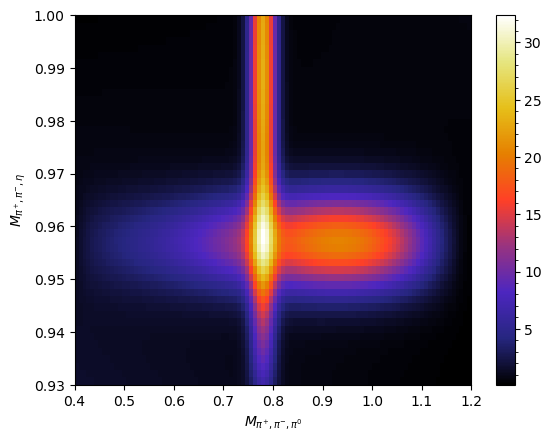

In [119]:
# Plot fit results

#Get fit parameters
fin_pars = [MT.params[k].value for k in Par_list]


# calculate the fitted values
xx,yy = np.meshgrid(h_exp.x_bin_center, h_exp.y_bin_center)
Sum_pdf = F_PDF_SUM((xx, yy), *fin_pars)
Sum = Sum_pdf[1]*h_exp.x_bin_width*h_exp.y_bin_width

h_fit = C.copy(h_exp)
h_fit.bin_content = Sum.T
#h_fit.bin_error = np.sqrt(h_fit.bin_content)
#h_res = h - h_fit
B.pl.figure();B.pl.close('all')
h_fit.plot()

print("Data events"+str(h_exp.sum()))
print("Fit events"+str(h_fit.sum()))
print("eta contribution= "+str(MT.params['e'].value))

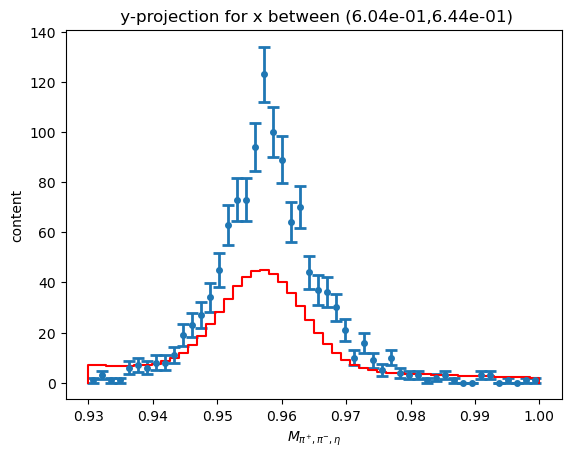

In [120]:
#%% compare etap projection
B.pl.figure(); B.pl.close('all')
o_range = (0.6, 0.65)
h_exp.project_y(range = o_range).plot_exp()
h_fit.project_y(range = o_range).plot(filled = False, color = 'r')

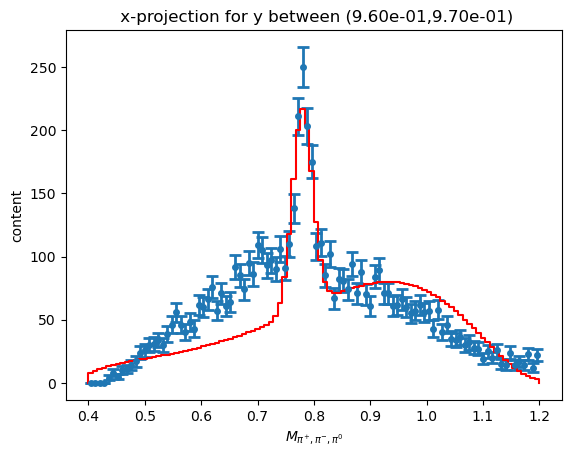

In [121]:
B.pl.figure()
e_range = (0.96,0.97)
h_exp.project_x(range = e_range).plot_exp()
h_fit.project_x(range = e_range).plot(filled = False, color = 'r')